___

<a href='http://www.pieriandata.com'><img src='../Pierian_Data_Logo.png'/></a>
___
<center><em>Copyright Pierian Data</em></center>
<center><em>For more information, visit us at <a href='http://www.pieriandata.com'>www.pieriandata.com</a></em></center>

# RNN Example for Time Series

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [3]:
df = pd.read_csv('RSCCASN.csv',index_col='DATE',parse_dates=True)

In [4]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [5]:
df.columns = ['Sales']

<Axes: xlabel='DATE'>

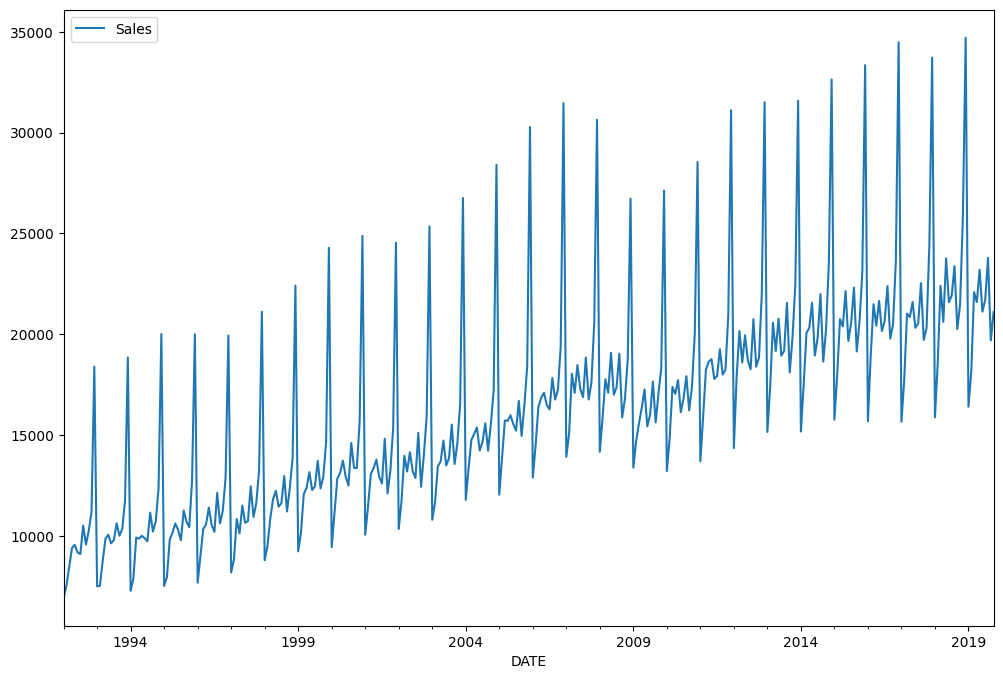

In [6]:
df.plot(figsize=(12,8))

## Train Test Split

In [37]:
len(df)

Data is monthly, let's forecast 1.5 years into the future.

In [38]:
len(df)- 18

316

In [39]:
test_size = 18

In [40]:
test_ind = len(df)- test_size

In [41]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [42]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [43]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


## Scale Data

In [44]:
from sklearn.preprocessing import MinMaxScaler

In [45]:
scaler = MinMaxScaler()

In [46]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler()

In [47]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [48]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [49]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [50]:
# What does the first batch look like?
X,y = generator[0]

In [51]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


### Create the Model

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [53]:
# We're only using one feature in our time series
n_features = 1

In [54]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [55]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### EarlyStopping and creating a Validation Generator

NOTE: The scaled_test dataset size MUST be greater than your length chosen for your batches. Review video for more info on this.

In [56]:
from tensorflow.keras.callbacks import EarlyStopping

In [57]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [58]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [59]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


C:\Users\Ivan\AppData\Local\Temp\ipykernel_12744\1350552164.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=20,


304/304 [==============================] - 3s 4ms/step - loss: 0.0271 - val_loss: 0.0027
Epoch 2/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0157 - val_loss: 0.0023
Epoch 3/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0088 - val_loss: 0.0071
Epoch 4/20
304/304 [==============================] - 1s 3ms/step - loss: 0.0060 - val_loss: 0.0030


In [60]:
losses = pd.DataFrame(model.history.history)

<Axes: >

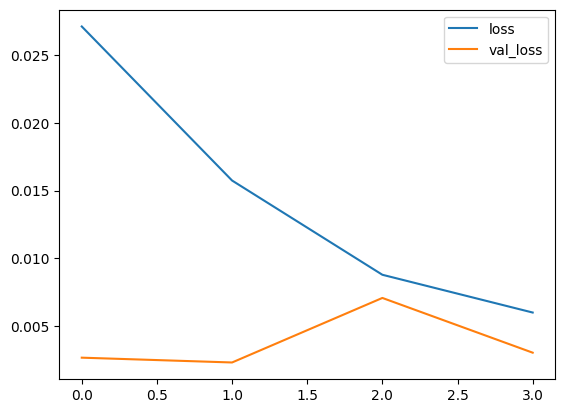

In [61]:
losses.plot()

## Evaluate on Test Data

In [62]:
first_eval_batch = scaled_train[-length:]

In [64]:
first_eval_batch = first_eval_batch.reshape((1, 12, n_features))

In [65]:
model.predict(first_eval_batch)

1/1 [==============================] - 0s 208ms/step


array([[0.47319177]], dtype=float32)

In [66]:
scaled_test[0]

array([0.61087714])

Now let's put this logic in a for loop to predict into the future for the entire test range.

----

**NOTE: PAY CLOSE ATTENTION HERE TO WHAT IS BEING OUTPUTED AND IN WHAT DIMENSIONS. ADD YOUR OWN PRINT() STATEMENTS TO SEE WHAT IS TRULY GOING ON!!**

In [67]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 19ms/step


## Inverse Transformations and Compare

In [68]:
true_predictions = scaler.inverse_transform(test_predictions)

In [69]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

C:\Users\Ivan\AppData\Local\Temp\ipykernel_12744\1339453577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [70]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,19971.594056
2018-06-01,21589,19353.221404
2018-07-01,21919,19439.097260
2018-08-01,23381,20344.693312
2018-09-01,20260,19084.213224
2018-10-01,21473,19395.212452
2018-11-01,25831,21397.819512
2018-12-01,34706,26848.268093
2019-01-01,16410,17140.577015


<Axes: xlabel='DATE'>

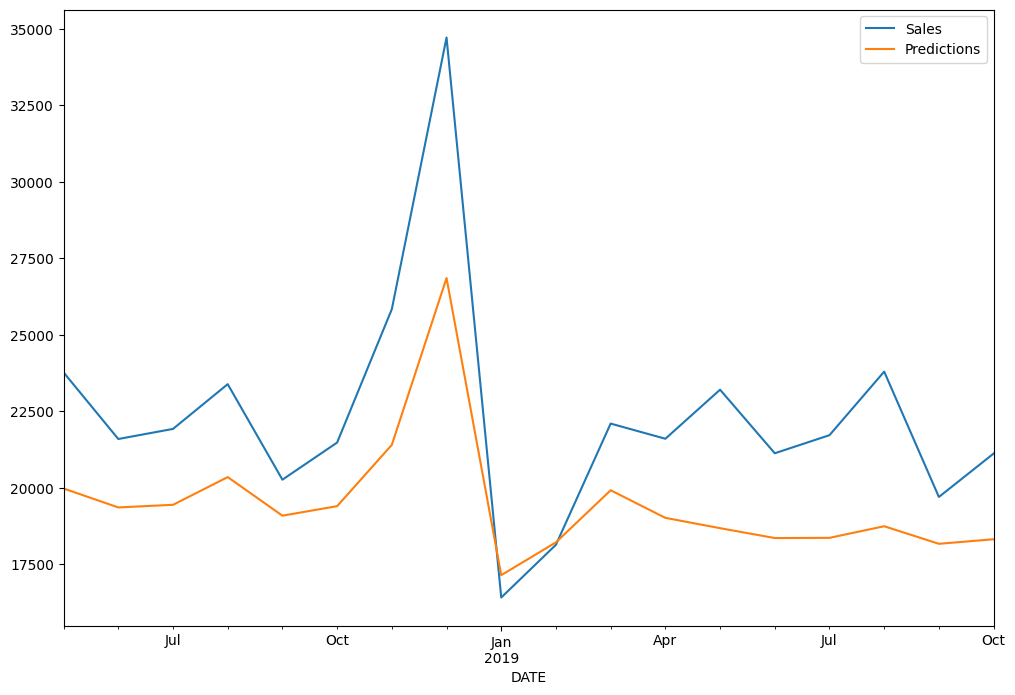

In [71]:
test.plot(figsize=(12,8))

# Retrain and Forecasting

In [72]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [73]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [74]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8


C:\Users\Ivan\AppData\Local\Temp\ipykernel_12744\853647718.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=8)


322/322 [==============================] - 2s 2ms/step - loss: 0.0244
Epoch 2/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0142
Epoch 3/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0061
Epoch 4/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0030
Epoch 5/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0023
Epoch 6/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0016
Epoch 7/8
322/322 [==============================] - 1s 3ms/step - loss: 0.0020
Epoch 8/8
322/322 [==============================] - 1s 4ms/step - loss: 0.0010


In [75]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 30ms/step


In [76]:
forecast = scaler.inverse_transform(forecast)

### Creating new timestamp index with pandas.

In [77]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [78]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [79]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [80]:
forecast_df

,Forecast
2019-11-01,26339.471605
2019-12-01,36877.445080
2020-01-01,17243.101861
2020-02-01,18794.365485
2020-03-01,22398.615741
2020-04-01,22051.694194
2020-05-01,23623.128363
2020-06-01,21758.154159
2020-07-01,22345.418105
2020-08-01,24262.902051


<Axes: >

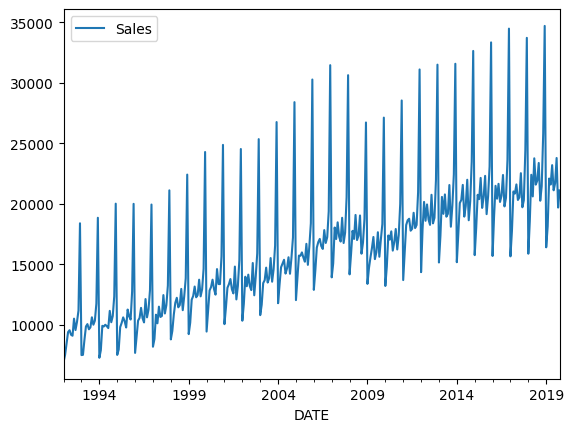

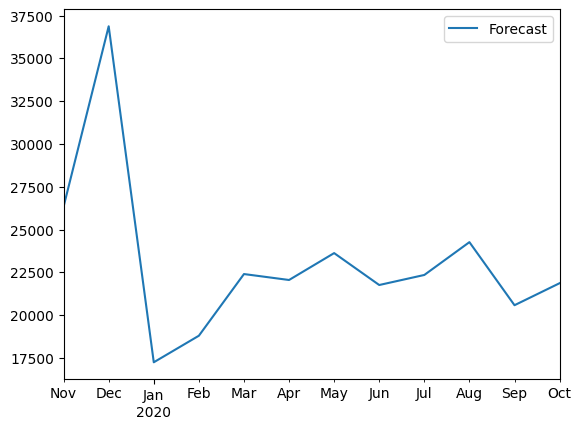

In [81]:
df.plot()
forecast_df.plot()

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

<Axes: xlabel='DATE'>

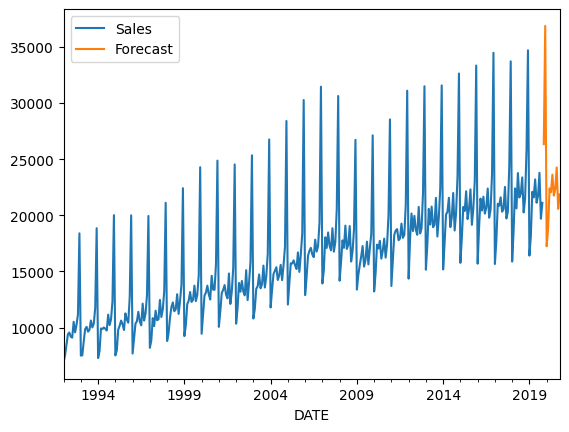

In [82]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

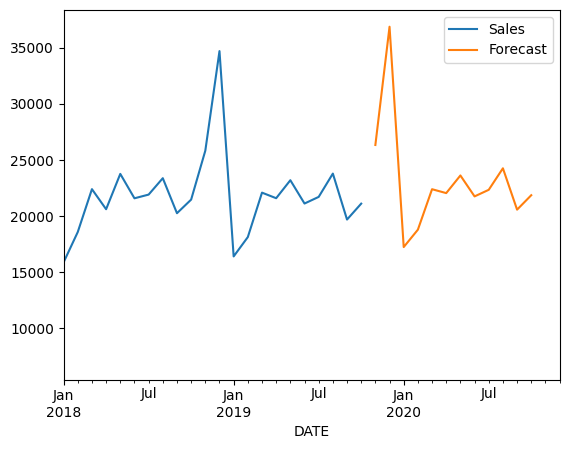

In [83]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')

# Great Job!